In [1]:
using QuantumClifford
using QuantumClifford.Experimental.NoisyCircuits
using Plots
using ProgressMeter

# Monte Carlo error vs Perturbative expansion error

The Monte Carlo method requires large number of samples to obtain a result with a small stochastic error. The scaling is $\mathrm{error}\propto\frac{1}{\sqrt{N}}$ where $N$ is the number of samples.

The perturbative expansion method's computational complexity grows exponentially in the order of the expansion, however at low order it can be more efficient than the Monte Carlo method for the same error. The error scales as $\varepsilon^n$ where $\varepsilon$ is the perturbative parameter (e.g. a small error rate) and $n$ is the order of the expansion. $n=1$ is the default for this software. The software supports symbolic evaluation (e.g. it provides analytical expansions).

Below we compare results obtained with either method and explore the accuracy of the result as a function of the $N$ and $\varepsilon$ parameters. The toy circuit on which we test these methods is the purification of a noisy Bell pair by the sacrifice of another noisy Bell pair. We report the rate of successful purification, detected failed purification, and undetected failures of purification (which are the source of imperfection afther the purification).

## Relative error

Comparing the two simulation methods in the case of a perfect purification circuit that purifies one Bell pair by sacrificing another Bell pair. Both pairs are subjected to depolarization noise before being used.

We run the Monte Carlo simulation with a 1000 samples and show how averaging over that many samples leads to a small stochastic error in the estimate. We report the histogram (distribution) of such relative errors over multiple runs of the Monte Carlo simulation.

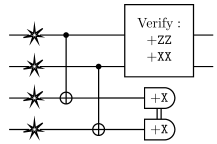

In [2]:
good_bell_state = S"XX
                    ZZ"
initial_state = good_bell_state⊗good_bell_state

g1 = SparseGate(CNOT, [1,3]) # CNOT between qubit 1 and qubit 3 (both with Alice)
g2 = SparseGate(CNOT, [2,4]) # CNOT between qubit 2 and qubit 4 (both with Bob)
m = BellMeasurement([X,X],[3,4]) # Bell measurement on qubit 3 and 4
v = VerifyOp(good_bell_state,[1,2]) # Verify that qubit 1 and 2 indeed form a good Bell pair
epsilon = 0.01 # The error rate
n = NoiseOpAll(UnbiasedUncorrelatedNoise(epsilon))

# This circuit performs a depolarization at rate `epsilon` to all qubits,
# then bilater CNOT operations
# then a Bell measurement
# followed by checking whether the final result indeed corresponds to the correct Bell pair.
circuit = [n,g1,g2,m,v]

In [3]:
N = 1000 # Nb of trajectories
relative_error(a,b, symbol) = abs(a[symbol]/N-b[symbol]) / (a[symbol]/N+b[symbol]+1e-5)
df = [] # store relative error in the detected failure rate
uf = [] # store relative error in the undetected failure rate
ts = [] # store relative error in the true success rate
pe = petrajectories(initial_state, circuit) # perturbative expansion
for i in 1:1000
    mc = mctrajectories(initial_state, circuit, trajectories=N) # Monte Carlo
    append!(df,relative_error(mc,pe,:detected_failure))
    append!(uf,relative_error(mc,pe,:undetected_failure))
    append!(ts,relative_error(mc,pe,:true_success))
end

Print the results according to the perturbative expansion:

In [4]:
pe

Dict{Symbol, Float64} with 3 entries:
  :undetected_failure => 0.0547604
  :detected_failure   => 0.0365069
  :true_success       => 0.903546

Compare the MC results to the perturbative expansion results:

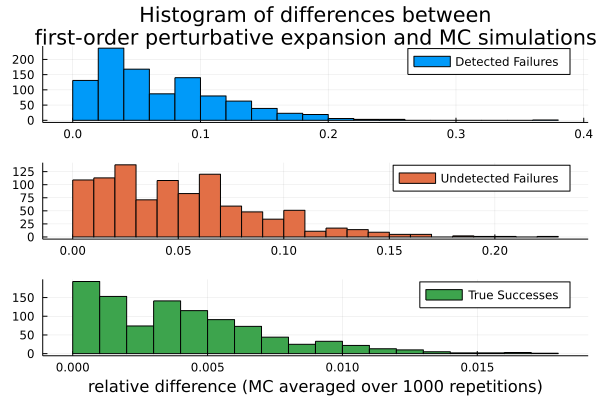

In [5]:
plot(histogram(df, label="Detected Failures",
               title="Histogram of differences between\nfirst-order perturbative expansion and MC simulations"),
     histogram(uf, label="Undetected Failures", color=2),
     histogram(ts, label="True Successes", color=3,
               xaxis="relative difference (MC averaged over $(N) repetitions)"),
     layout=(3,1),legend=true)

Notice that the sum of probabilities in the perturbative expansion is less than one, as only the leading order is kept.

In [6]:
sum(values(pe))

0.9948135699999998

It is instructive to see how the purification procedure compares to no purification:

In [7]:
pe_nopurification = petrajectories(initial_state, [n,v])

Dict{Symbol, Float64} with 3 entries:
  :undetected_failure => 0.0547604
  :detected_failure   => 0.0
  :true_success       => 0.940053

## Larger number of samples lowers the MC error

As already mentioned the stochastic error in the MC approach scales as $\frac{1}{\sqrt{N}}$. The plot below demonstrates how using larger number of samples makes the answer from the Monte Carlo approach more precise.

In [8]:
Ns = [50,100,10^0.5*100,1000,10000]
reps = 20
pe = petrajectories(initial_state, circuit) # perturbative expansion
DF,UF,TS = [],[],[]
for N in Ns
    df,uf,ts = [],[],[]
    @showprogress for i in 1:reps
        mc = mctrajectories(initial_state, circuit, trajectories=N) # Monte Carlo
        push!(df,mc[:detected_failure]/N)
        push!(uf,mc[:undetected_failure]/N)
        push!(ts,mc[:true_success]/N)
    end
    push!(DF,df)
    push!(UF,uf)
    push!(TS,ts)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


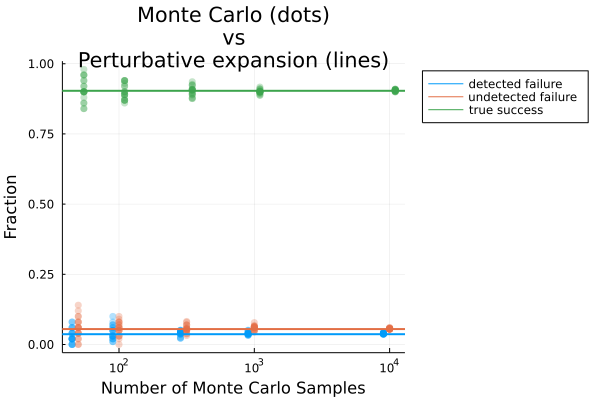

In [9]:
plot()
for (N, df, uf, ts) in zip(Ns, DF, UF, TS)
    scatter!(ones(reps)*N*0.9,df,label="",color=1,markerstrokewidth=0,alpha=0.3)
    scatter!(ones(reps)*N,    uf,label="",color=2,markerstrokewidth=0,alpha=0.3)
    scatter!(ones(reps)*N*1.1,ts,label="",color=3,markerstrokewidth=0,alpha=0.3)
end
hline!([pe[:detected_failure]],  color=1,lw=2,label="detected failure")
hline!([pe[:undetected_failure]],color=2,lw=2,label="undetected failure")
hline!([pe[:true_success]],      color=3,lw=2,label="true success")
plot!(xaxis=:log10,legend=:outertopright,
      xlabel="Number of Monte Carlo Samples",
      ylabel="Fraction",
      title="Monte Carlo (dots)\nvs\nPerturbative expansion (lines)"
     )

## Large perturbation lowers the precision of the perturbative approach

We already saw that the probabilities in the perturbative solution do not sum up to unity. Here we see how this imprecision grows as $\varepsilon$ grows.

In [10]:
N = 100000
εs = 0.01:0.003:0.08
PE = []
MC = []
@showprogress for ε in εs
    nε = NoiseOpAll(UnbiasedUncorrelatedNoise(ε))
    circuit = [nε,g1,g2,m,v]
    pe = petrajectories(initial_state, circuit) # perturbative expansion
    mc = mctrajectories(initial_state, circuit, trajectories=N) # Monte Carlo
    push!(PE,pe)
    push!(MC,mc)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


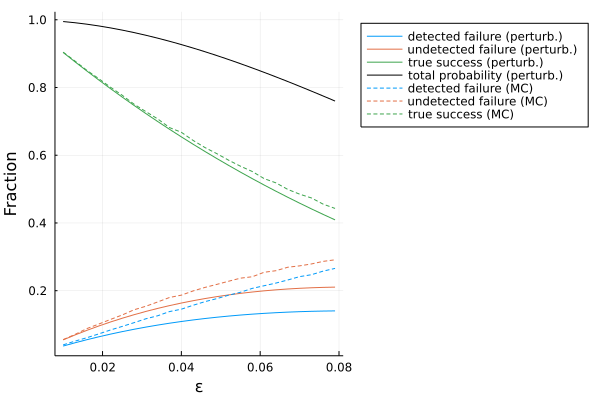

In [11]:
plot( εs, [pe[:detected_failure]   for pe in PE], color=1, label="detected failure (perturb.)")
plot!(εs, [pe[:undetected_failure] for pe in PE], color=2, label="undetected failure (perturb.)")
plot!(εs, [pe[:true_success]       for pe in PE], color=3, label="true success (perturb.)")
plot!(εs, [sum(values(pe)) for pe in PE], color=:black, label="total probability (perturb.)")
plot!(εs, [mc[:detected_failure]/N   for mc in MC], color=1, line=:dash, label="detected failure (MC)")
plot!(εs, [mc[:undetected_failure]/N for mc in MC], color=2, line=:dash, label="undetected failure (MC)")
plot!(εs, [mc[:true_success]/N       for mc in MC], color=3, line=:dash, label="true success (MC)")
plot!(legend=:outertopright, xlabel="ε", ylabel="Fraction")

As seen above, the error in the perturbative approach can be much too large for large $\varepsilon$.

## Reproducibility information

In [12]:
versioninfo()
using Pkg
Pkg.status("QuantumClifford")

Julia Version 1.7.1
Commit ac5cc99908 (2021-12-22 19:35 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: AMD Ryzen 7 1700 Eight-Core Processor
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, znver1)
      Status `~/Documents/ScratchSpace/clifford/Project.toml`
  [0525e862] QuantumClifford v0.3.0 `QuantumClifford`
